# Assignment - 2

**Name:** *Nithesh Kumar Manimaran*

**Date:** *08/01/2023*

**Title:** *Detect your favourite pet*

# Objective

Place a square box around your favourite pet in the image.

# Mission Statement

* Create your own dataset from pre-existing datasets.
* Describe your final dataset.
* Define your modelisation strategy.
* Use OpenCV to accomplish this task and then a specialized framework for
object detection of your choice

# Deliverables

* Introduction
* Dataset loading
* Data exploration
* Preprocessing
* Modelization
* Performances evaluation
* Conclusion

## Step 1: Introduction

* The objective of this assignment is to detect a pet in an image.
* The pet chose is a raccoon.
* The dataset used is Raccoon Dataset - [Link](https://www.kaggle.com/datasets/debasisdotcom/racoon-detection/download?datasetVersionNumber=1)
* Annotations are in XML format - [Link](https://github.com/datitran/raccoon_dataset/tree/master/annotations)

For this assignment, I have used the following techniques:
1. Haar Cascade Classifier
2. Baseline Model
3. MobileNetV2 using Transfer Learning with Imagenet weights
4. MobileNet with custom loss function IoU (Intersection over Union)

* References
* https://pyimagesearch.com/2020/10/05/object-detection-bounding-box-regression-with-keras-tensorflow-and-deep-learning/
* https://towardsdatascience.com/object-localization-using-pre-trained-cnn-models-such-as-mobilenet-resnet-xception-f8a5f6a0228d
* https://medium.com/@vipulgote4/guide-to-make-custom-haar-cascade-xml-file-for-object-detection-with-opencv-6932e22c3f0e

## Step 2: Dataset loading

Now after downloading the data images and annotations from the links we have our dataset.

But This data is not sufficient for training a model.

So different steps in the below section are performed to create a final dataset.

### Step 2.1: Dataset Preparation for Haar Cascade Classifier

* The dataset is split into positive and negative samples.
* The positive samples are the images with raccoon in it.
* The negative samples are the images without raccoon in it.

We have 200 raccoons in positive samples
For the negative samples, we use open ai image dataset to download negative samples.

In [9]:
# Dataset Preparation - Using open images fiftyone to download cat,hamster,elephant,fish as negative samples
import fiftyone as fo
import fiftyone.zoo as foz

# Load the dataset
dataset = foz.load_zoo_dataset("open-images-v6",
    dataset_name="open-images-neg",
    label_types=["detections"],
    classes=["Cat", "Hamster", "Elephant", "Fish","Bird","Horse"],
    max_samples=200,
    split="validation",
    shuffle=True,
    seed=51,
    dataset_dir="../Project_2/dataset/temp/n"
)


 100% |███████████████████| 200/200 [7.3s elapsed, 0s remaining, 29.1 files/s]      
Dataset info written to '../Project_2/dataset/temp/n\info.json'
Loading existing dataset 'open-images-neg'. To reload from disk, either delete the existing dataset or provide a custom `dataset_name` to use


### Step 2.2: Dataset Preparation for Baseline Model and MobileNetV2

* The dataset is split into train and test samples which is going to be used for training and testing the model.
* The train samples are the images with raccoon in it.
* The test samples are the images without raccoon in it.

Inorder to generate this data we used the build_dataset.py

```python
build_dataset.py
```

This script will generate the train and test data.

How does this script work?
1. Create the positive and negative output directories if they don't already exist.

2. Load all image paths in the input image directory and initialize counters to keep track of the total number of positive and negative images saved to disk.

3. Loop over each image path and its associated annotation file:

    * Parse the annotation file to extract the ground-truth bounding boxes for that image.
    * Load the image and run selective search on it to generate a list of region proposals.
    * Loop over each region proposal:
        * Compute the intersection over union (IoU) between the proposal and each ground-truth bounding box.
        * If the IoU is greater than a certain threshold (specified in the config module), save the proposal to disk in the positive output directory as a positive region of interest (ROI).
        * If the IoU is less than a certain threshold, save the proposal to disk in the negative output directory as a negative ROI.
4. Continue this process until the maximum number of ROIs specified in the config module have been saved.

### Step 2.3: Dataset Preparation for MobileNet with custom loss function IoU

For this step, we have used the same dataset as the baseline model.

In [5]:
!python /content/drive/MyDrive/Computer_Vision/Project_2/build_dataset.py

[INFO] processing image 1/200
[INFO] processing image 2/200
[INFO] processing image 3/200
[INFO] processing image 4/200
[INFO] processing image 5/200
[INFO] processing image 6/200
[INFO] processing image 7/200
[INFO] processing image 8/200
[INFO] processing image 9/200
[INFO] processing image 10/200
[INFO] processing image 11/200
[INFO] processing image 12/200
[INFO] processing image 13/200
[INFO] processing image 14/200
[INFO] processing image 15/200
[INFO] processing image 16/200
[INFO] processing image 17/200
[INFO] processing image 18/200
[INFO] processing image 19/200
[INFO] processing image 20/200
[INFO] processing image 21/200
[INFO] processing image 22/200
[INFO] processing image 23/200
[INFO] processing image 24/200
[INFO] processing image 25/200
[INFO] processing image 26/200
[INFO] processing image 27/200
[INFO] processing image 28/200
[INFO] processing image 29/200
[INFO] processing image 30/200
[INFO] processing image 31/200
[INFO] processing image 32/200
[INFO] processing

## Step 3: Data exploration

In [1]:
# No of images ORIG_IMAGES

import os
import glob
from config import config

ORIG_IMAGES = config.ORIG_IMAGES
ORIG_ANNOTS = config.ORIG_ANNOTS

print(len(os.listdir(ORIG_IMAGES)))
print(len(os.listdir(ORIG_ANNOTS)))

200
200


In [2]:
# No of images in dataset after build_dataset.py

POSITVE_PATH = config.POSITVE_PATH
NEGATIVE_PATH = config.NEGATIVE_PATH

print(len(os.listdir(POSITVE_PATH)))
print(len(os.listdir(NEGATIVE_PATH)))

1555
2200


In [3]:
train_labels_csv = config.CSV

import pandas as pd
df = pd.read_csv(train_labels_csv)
df.head()

,filename,width,height,class,xmin,ymin,xmax,ymax
0,raccoon-17.jpg,259,194,raccoon,95,60,167,118
1,raccoon-11.jpg,660,432,raccoon,3,1,461,431
2,raccoon-63.jpg,600,400,raccoon,74,107,280,290
3,raccoon-63.jpg,600,400,raccoon,227,93,403,298
4,raccoon-60.jpg,273,185,raccoon,58,33,197,127


In [8]:
# Aspect ration of images in dataset

#Checking if the aspect ratio of the images is same or not
import cv2
import os
import glob
from config import config

POSITVE_PATH = config.POSITVE_PATH
NEGATIVE_PATH = config.NEGATIVE_PATH

def aspect_ratio(path):
    for img in os.listdir(path):
        image = cv2.imread(os.path
                            .join(path,img))
        height, width, channels = image.shape
        aspect_ratio = width/height
        if aspect_ratio != 1:
            print(img, aspect_ratio)
            break
        else:
            pass
    return ('All images have same aspect ratio')

print("Positive images")
aspect_ratio(POSITVE_PATH)
print("Negative images")
aspect_ratio(NEGATIVE_PATH)

Positive images
Negative images


'All images have same aspect ratio'

## Step 4: Preprocessing + Modelization of Different Techniques


---

Technique - 1: Haar Cascade Classifier

---

After training our own classifier using two techniques

1. GUI
2. Create a directory of positive and negative images and train using the command line. Like the temp folder in the above directory structure.
3. We can use the classifier to detect the object in the image.
4. opencv_createsample utility is used to create the positive and negative images.
5. The positive images are the images which contains the object we want to detect.
6. The negative images are the images which does not contain the object we want to detect.
7. opencv_traincascade utility is used to train the classifier.
8. The classifier is trained using the positive and negative images.
9. The classifier is saved in the form of xml file.
10. The classifier is used to detect the object in the image.


In [14]:
cascade_filename = 'cascade.xml'
img_filename = '1.jpg'

imagePath = "../Project_2/test_images/" + img_filename
cascadePath = "../Project_2/cascades/" + cascade_filename

# Create the haar cascade
faceCascade = cv2.CascadeClassifier(cascadePath)

# Read the image
image = cv2.imread(imagePath)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Detect faces in the image
faces = faceCascade.detectMultiScale(
    gray,
    scaleFactor=1.1,
    minNeighbors=5,
    minSize=(30, 30),
    flags = cv2.CASCADE_SCALE_IMAGE
)


# Draw a rectangle around the faces
for (x, y, w, h) in faces:
    cv2.rectangle(image, (x, y), (x+w, y+h), (0, 255, 0), 2)

cv2.imshow("Faces found", image)
cv2.waitKey(0)
cv2.destroyAllWindows()

---

Technique - 2: Baseline Model

---

* Working of the baseline model

The code imports various libraries including TensorFlow and scikit-learn. It also defines some custom functions such as baseline_model() which creates a CNN model with a specified number of classes.

The code reads in a list of image file paths and loads the images into memory, storing the image data in a NumPy array called data and the image labels in a list called labels.

The image labels are transformed using one-hot encoding and then split into training and testing sets using scikit-learn's train_test_split function.

An image generator is created using TensorFlow's ImageDataGenerator class with data augmentation parameters specified. This generator will be used to produce additional training data by applying random transformations to the training images.

The CNN model is created using the baseline_model() function and compiled with a binary cross-entropy loss function and the Adam optimizer.

The model is then fit to the training data using the fit method, which trains the model on the training data and evaluates it on the validation data. The training process includes data augmentation using the image generator created earlier.

After training, the code generates a classification report for the model on the test data and plots the model's training and validation accuracy over time.

In [15]:
#from config import config
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.layers.convolutional import Conv2D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dense
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import pickle
import os

In [19]:
imagePaths = list(paths.list_images(config.BASE_PATH))
data = []
labels = []

for imagePath in imagePaths:
    label = imagePath.split(os.path.sep)[-2]
    image = load_img(imagePath, target_size=(224,224))
    image = img_to_array(image)
    image = preprocess_input(image)

    data.append(image)
    labels.append(label)

In [21]:
# convert the data and labels to NumPy arrays
data = np.array(data, dtype="float32")
labels = np.array(labels)

# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

In [22]:
# partition the data into training and testing splits using 80% of
# the data for training and the remaining 20% for testing
(trainX, testX, trainY, testY) = train_test_split(data, labels,
    test_size=0.20, stratify=labels, random_state=42)
    

In [23]:
# construct the training image generator for data augmentation
aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

Simple Baseline Model

In [24]:
def baseline_model(width, height, depth, classes):
    # initialize the model
    model = Sequential()

    # add the first convolutional layer
    model.add(Conv2D(32, (3, 3), padding="same",
    	input_shape=(height, width, depth)))
    model.add(Activation("relu"))

    # add the second convolutional layer
    model.add(Conv2D(32, (3, 3)))
    model.add(Activation("relu"))

    # add the third convolutional layer
    model.add(Conv2D(64, (3, 3), padding="same"))
    model.add(Activation("relu"))

    # add a flattening layer
    model.add(Flatten())
    model.add(Dense(classes))
    model.add(Activation("softmax"))

    # return the constructed network architecture
    return model

In [25]:
model = baseline_model(224, 224, 3, len(lb.classes_))

model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 activation (Activation)     (None, 224, 224, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 222, 222, 32)      9248      
                                                                 
 activation_1 (Activation)   (None, 222, 222, 32)      0         
                                                                 
 conv2d_2 (Conv2D)           (None, 222, 222, 64)      18496     
                                                                 
 activation_2 (Activation)   (None, 222, 222, 64)      0         
                                                                 
 flatten (Flatten)           (None, 3154176)           0

In [27]:
H = model.fit(
    x= trainX, y= trainY,
    validation_data=(testX, testY),
    batch_size=32,
    epochs=10,
    verbose=1)

Epoch 1/10
94/94 [==============================] - 29s 179ms/step - loss: 1.2868 - accuracy: 0.8634 - val_loss: 0.1002 - val_accuracy: 0.9680
Epoch 2/10
94/94 [==============================] - 15s 155ms/step - loss: 0.1062 - accuracy: 0.9646 - val_loss: 0.0856 - val_accuracy: 0.9786
Epoch 3/10
94/94 [==============================] - 15s 155ms/step - loss: 0.0413 - accuracy: 0.9866 - val_loss: 0.0889 - val_accuracy: 0.9706
Epoch 4/10
94/94 [==============================] - 15s 155ms/step - loss: 0.0135 - accuracy: 0.9970 - val_loss: 0.1545 - val_accuracy: 0.9786
Epoch 5/10
94/94 [==============================] - 14s 154ms/step - loss: 0.0105 - accuracy: 0.9977 - val_loss: 0.0963 - val_accuracy: 0.9800
Epoch 6/10
94/94 [==============================] - 14s 153ms/step - loss: 0.0080 - accuracy: 0.9977 - val_loss: 0.2114 - val_accuracy: 0.9666
Epoch 7/10
94/94 [==============================] - 14s 154ms/step - loss: 0.0029 - accuracy: 0.9997 - val_loss: 0.1095 - val_accuracy: 0.9826

In [28]:
predictions = model.predict(testX, batch_size=32)
print(classification_report(testY.argmax(axis=1),
	predictions.argmax(axis=1), target_names=lb.classes_))

24/24 [==============================] - 2s 60ms/step
              precision    recall  f1-score   support

  no_raccoon       0.98      0.99      0.99       440
     raccoon       0.98      0.98      0.98       309

    accuracy                           0.98       749
   macro avg       0.98      0.98      0.98       749
weighted avg       0.98      0.98      0.98       749



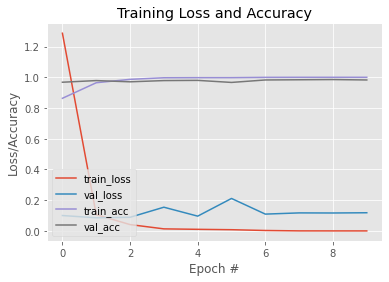

In [29]:
# plot the training loss and accuracy
N = 10
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")

In [32]:
model.save('D:/EPITA/Computer_Vision/Project_2/output/baseline_model.h5',save_format='h5')

---

Technique - 3: MobileNetV2 using Transfer Learning with Imagenet weights

---

These changes modify the original code to train a new model using the MobileNetV2 architecture with ImageNet weights as the base model, rather than the custom CNN model defined in the baseline_model() function. The MobileNetV2 model is imported from TensorFlow's applications module and its weights are set to the ImageNet weights using the weights argument. The base model's layers are frozen so they will not be updated during training.

A new model is then constructed by adding additional layers on top of the base model. This new model consists of an average pooling layer, a flatten layer, two fully connected (Dense) layers with ReLU activation, and a final output layer with softmax activation.

The new model is compiled using the Adam optimizer, binary cross-entropy loss, and accuracy as the metric. It is then trained using the fit method, with data augmentation provided by the image generator.

After training, the model's performance is evaluated on the test data using a classification report and a plot of the training and validation loss and accuracy. The model's predictions on the test data are also obtained using the predict method.

In [33]:
# With MobileNetV2 - imagenet wieghts

baseModel = MobileNetV2(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))
# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)
# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)
# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
	layer.trainable = False

9406464/9406464 [==============================] - 0s 0us/step


In [35]:
INIT_LR = 1e-4
EPOCHS = 5
BS = 32

opt = Adam(learning_rate = INIT_LR)
model.compile(loss = 'binary_crossentropy', optimizer =opt, metrics = ['accuracy'])

In [36]:
H1 = model.fit(
	aug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=EPOCHS)

Epoch 1/5
93/93 [==============================] - 36s 347ms/step - loss: 0.2506 - accuracy: 0.9230 - val_loss: 0.0488 - val_accuracy: 0.9933
Epoch 2/5
93/93 [==============================] - 35s 381ms/step - loss: 0.0439 - accuracy: 0.9956 - val_loss: 0.0268 - val_accuracy: 0.9947
Epoch 3/5
93/93 [==============================] - 31s 330ms/step - loss: 0.0255 - accuracy: 0.9953 - val_loss: 0.0217 - val_accuracy: 0.9947
Epoch 4/5
93/93 [==============================] - 34s 371ms/step - loss: 0.0209 - accuracy: 0.9956 - val_loss: 0.0191 - val_accuracy: 0.9960
Epoch 5/5
93/93 [==============================] - 39s 420ms/step - loss: 0.0152 - accuracy: 0.9966 - val_loss: 0.0203 - val_accuracy: 0.9960


In [37]:
predIdxs = model.predict(testX, batch_size=BS)

# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs,
	target_names=lb.classes_))

24/24 [==============================] - 2s 57ms/step
              precision    recall  f1-score   support

  no_raccoon       1.00      0.99      1.00       440
     raccoon       0.99      1.00      1.00       309

    accuracy                           1.00       749
   macro avg       1.00      1.00      1.00       749
weighted avg       1.00      1.00      1.00       749



In [39]:
modelPath = 'D:/EPITA/Computer_Vision/Project_2/output/MobileNetV2_model.h5'
encoderPath = 'D:/EPITA/Computer_Vision/Project_2/output/enocoder.pickle'

model.save(modelPath, save_format='h5')
f = open(encoderPath,"wb")
f.write(pickle.dumps(lb))
f.close()

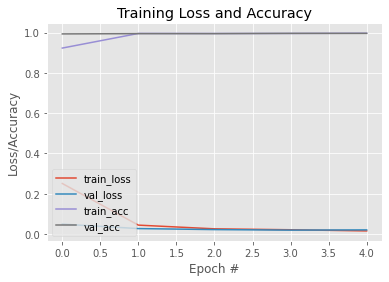

In [41]:
# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H1.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H1.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H1.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H1.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")

In [3]:
# Detecting for an image
from config import config
from tensorflow.keras.models import load_model
model = load_model(config.MODEL_PATH + '/MobileNetV2_model.h5')
lb = pickle.loads(open(config.ENCODER_PATH,"rb").read())

c:\Users\nithe\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator LabelBinarizer from version 1.0.2 when using version 1.1.3. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [4]:
import imutils
import cv2
image = cv2.imread('D:/EPITA/Computer Vision/Project_2/test_images/Raccoon_in_Central_Park_(35264).jpg')
image = imutils.resize(image, width = 500)

ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
ss.setBaseImage(image)
ss.switchToSelectiveSearchFast()
rects = ss.process()

proposals = []
boxes = []

for (x, y, w, h) in rects[:config.MAX_PROPOSALS_INFER]:
	# extract the region from the input image, convert it from BGR to
	# RGB channel ordering, and then resize it to the required input
	# dimensions of our trained CNN
	roi = image[y:y + h, x:x + w]
	roi = cv2.cvtColor(roi, cv2.COLOR_BGR2RGB)
	roi = cv2.resize(roi, config.INPUT_DIMS,
		interpolation=cv2.INTER_CUBIC)
	# further preprocess the ROI
	roi = img_to_array(roi)
	roi = preprocess_input(roi)
	# update our proposals and bounding boxes lists
	proposals.append(roi)
	boxes.append((x, y, x + w, y + h))
 
proposals = np.array(proposals, dtype="float32")
boxes = np.array(boxes, dtype="int32")
proba = model.predict(proposals)
labels = lb.classes_[np.argmax(proba, axis=1)]

7/7 [==============================] - 7s 669ms/step


In [5]:
idxs = np.where(labels == "raccoon")[0]
boxes = boxes[idxs]
proba = proba[idxs][:, 1]

idxs = np.where(proba >= config.MIN_PROBA)
boxes = boxes[idxs]
proba = proba[idxs]

clone = image.copy()

# loop over the bounding boxes and associated probabilities
for (box, prob) in zip(boxes, proba):
	# draw the bounding box, label, and probability on the image
	(startX, startY, endX, endY) = box
	cv2.rectangle(clone, (startX, startY), (endX, endY),
		(0, 255, 0), 2)
	y = startY - 10 if startY - 10 > 10 else startY + 10
	text= "Raccoon: {:.2f}%".format(prob * 100)
	cv2.putText(clone, text, (startX, y),
		cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 255, 0), 2)

In [8]:
(startX, startY, endX, endY) = boxes[0]
cv2.rectangle(clone, (startX, startY), (endX, endY), (0, 255, 0), 2)
y = startY - 10 if startY - 10 > 10 else startY + 10
text= "Raccoon: {:.2f}%".format(proba[0] * 100)
cv2.putText(clone, text, (startX, y), cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 255, 0), 2)

cv2.imshow("Output", clone)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [7]:
# Displaying the image
cv2.imshow("Output", clone)
cv2.waitKey(0)
cv2.destroyAllWindows()


---

Technique 4: MobileNet with custom loss function IoU

---

Training a neural network using the MobileNet architecture to perform object detection on images. The network takes in images and predicts the coordinates of the bounding box surrounding an object in the image. The training data consists of images and the corresponding bounding box coordinates, which are read in from a CSV file. The bounding box coordinates are normalized by dividing them by the width or height of the image. The images are then resized to 128x128 and preprocessed. The MobileNet model is then constructed with the last layer changed to a Conv2D layer with 4 filters, which outputs the predicted bounding box coordinates. 

A custom loss function based on Intersection over Union (IOU) is defined to train the model. The model is then fit on the training data using this loss function.

In [32]:
import tensorflow
import random
import csv
import numpy as np
from config import config
random.seed(42)
tensorflow.__version__


'2.11.0'

In [19]:
project_path = 'D:/EPITA/Computer Vision/Project_2'
data_path = project_path + '/raccoons/images'
train_csv_path = project_path + '/dataset/train_labels_.csv'
IMAGE_SIZE = 128

In [20]:
normalise = lambda coordinate, value: (coordinate * IMAGE_SIZE) / value

with open (train_csv_path, 'r') as csvfile:
    y_train = np.zeros((sum(1 for line in csvfile)-1, 4))
    X_train=[]
    csvfile.seek(0)
    data = csv.reader(csvfile, delimiter=',')
    next(data)
    for index, row in enumerate(data):
        for i,r in enumerate(row[x] for x in [1,2,4,5,6,7]):
            row[i+1] = int(r)
        path,image_width,image_height,x0,y0,x1,y1,_ = row
        path = data_path + '/' + path

        y_train[index,0] = normalise(x0, image_width)
        y_train[index,1] = normalise(y0, image_height)
        y_train[index,2] = normalise(x1, image_width)
        y_train[index,3] = normalise(y1, image_height)

        X_train.append(path)

In [21]:
X_train[0:5]

['D:/EPITA/Computer Vision/Project_2/raccoons/images/raccoon-17.jpg',
 'D:/EPITA/Computer Vision/Project_2/raccoons/images/raccoon-11.jpg',
 'D:/EPITA/Computer Vision/Project_2/raccoons/images/raccoon-63.jpg',
 'D:/EPITA/Computer Vision/Project_2/raccoons/images/raccoon-63.jpg',
 'D:/EPITA/Computer Vision/Project_2/raccoons/images/raccoon-60.jpg']

In [22]:
y_train[0:5]

array([[ 46.94980695,  39.58762887,  82.53281853,  77.8556701 ],
       [  0.58181818,   0.2962963 ,  89.40606061, 127.7037037 ],
       [ 15.78666667,  34.24      ,  59.73333333,  92.8       ],
       [ 48.42666667,  29.76      ,  85.97333333,  95.36      ],
       [ 27.19413919,  22.83243243,  92.36630037,  87.87027027]])

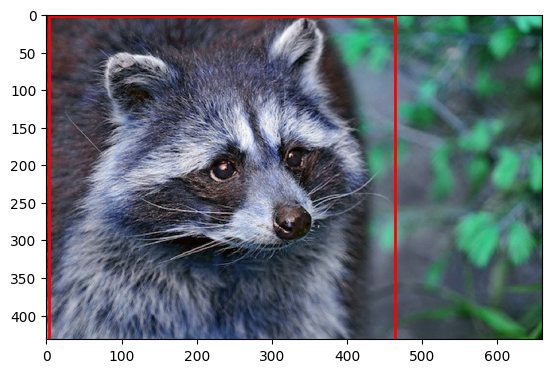

In [23]:

import matplotlib.pyplot as plt
import matplotlib.patches as patches
# resize the image to 128*128
import cv2

#pick up a random image
filename = X_train[1]
unscaled = cv2.imread(filename)
region = y_train[1]

image_height, image_width, _ = unscaled.shape

x0= int(region[0] * image_width / IMAGE_SIZE)
y0= int(region[1] * image_height / IMAGE_SIZE)

x1= int((region[0] + region[2])* image_width / IMAGE_SIZE)
y1= int((region[1] + region[3])* image_height / IMAGE_SIZE)


fig, axis = plt.subplots(1)
axis.imshow(unscaled)

rect = patches.Rectangle((x0, y0), x1-x0, y1-y0, linewidth=2, edgecolor='r', facecolor='none')

axis.add_patch(rect)

plt.show()


In [24]:
from PIL import Image
from tensorflow.keras.applications.mobilenet import preprocess_input

for i, f in enumerate(X_train):
  img = Image.open(f)
  img = img.resize((IMAGE_SIZE, IMAGE_SIZE))
  img = img.convert('RGB')

  X_train[i] = preprocess_input(np.array(img, dtype=np.float32))
  img.close()

In [25]:
X_train = np.array(X_train)
X_train.shape

(173, 128, 128, 3)

In [26]:
y_train.shape

(173, 4)

In [27]:
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, Reshape

ALPHA=1

def create_model(trainable=True):
  model = MobileNet(input_shape=(IMAGE_SIZE,IMAGE_SIZE,3), include_top=False, alpha=ALPHA)

  # freez the layers which we have till now from training
  for layer in model.layers:
    layer.trainable = trainable

  x0 = model.layers[-1].output
  x1 = Conv2D(4, kernel_size=4, name='coords')(x0)

  x2 = Reshape((4,))(x1)

  return Model(inputs = model.input, outputs=x2)

# Custom Loss Function IoU (Intersection over Union)

In [28]:
from tensorflow.keras.backend import epsilon
def loss(gt,pred):
    intersections = 0
    unions = 0
    diff_width = np.minimum(gt[:,0] + gt[:,2], pred[:,0] + pred[:,2]) - np.maximum(gt[:,0], pred[:,0])
    diff_height = np.minimum(gt[:,1] + gt[:,3], pred[:,1] + pred[:,3]) - np.maximum(gt[:,1], pred[:,1])
    intersection = diff_width * diff_height
    
    # Compute union
    area_gt = gt[:,2] * gt[:,3]
    area_pred = pred[:,2] * pred[:,3]
    union = area_gt + area_pred - intersection

#     Compute intersection and union over multiple boxes
    for j, _ in enumerate(union):
        if union[j] > 0 and intersection[j] > 0 and union[j] >= intersection[j]:
            intersections += intersection[j]
            unions += union[j]

    # Compute IOU. Use epsilon to prevent division by zero
    iou = np.round(intersections / (unions + epsilon()), 4)
    iou = iou.astype(np.float32)
    return iou

def IoU(y_true, y_pred):
    iou = tensorflow.py_function(loss, [y_true, y_pred], tensorflow.float32)
    return iou

In [29]:
model = create_model(False)
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 64, 64, 32)        864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 64, 64, 32)       128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 64, 64, 32)        0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 64, 64, 32)       288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 64, 64, 32)       128       
 ation)                                                    

In [30]:
model.compile(loss='mean_squared_error', optimizer='adam', metrics=[IoU])

In [33]:
model.fit(X_train, y_train, epochs=50, batch_size=32)

Epoch 1/50
6/6 [==============================] - 3s 396ms/step - loss: 50.5332 - IoU: 0.8830
Epoch 2/50
6/6 [==============================] - 2s 304ms/step - loss: 49.5153 - IoU: 0.8814
Epoch 3/50
6/6 [==============================] - 2s 305ms/step - loss: 50.4885 - IoU: 0.8670
Epoch 4/50
6/6 [==============================] - 2s 325ms/step - loss: 51.8054 - IoU: 0.8685
Epoch 5/50
6/6 [==============================] - 2s 334ms/step - loss: 51.7283 - IoU: 0.8533
Epoch 6/50
6/6 [==============================] - 2s 314ms/step - loss: 50.7377 - IoU: 0.8635
Epoch 7/50
6/6 [==============================] - 2s 327ms/step - loss: 48.6903 - IoU: 0.8689
Epoch 8/50
6/6 [==============================] - 2s 348ms/step - loss: 51.3377 - IoU: 0.8646
Epoch 9/50
6/6 [==============================] - 2s 331ms/step - loss: 53.5138 - IoU: 0.8543
Epoch 10/50
6/6 [==============================] - 2s 313ms/step - loss: 52.9545 - IoU: 0.8700
Epoch 11/50
6/6 [==============================] - 2s 350ms

In [36]:
# Save the model
model.save(config.MODEL_PATH + 'IOU.h5')

1/1 [==============================] - 1s 1s/step


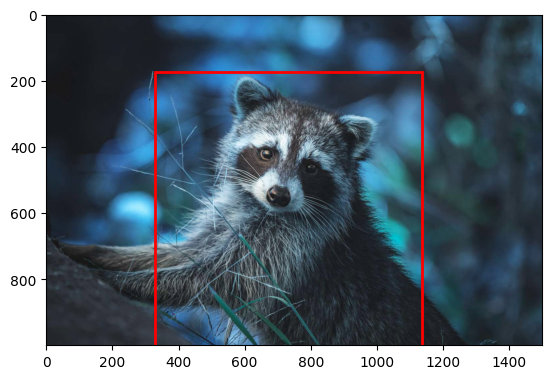

In [35]:
# Predict the bounding box for an image

imgPath = 'D:/EPITA/Computer Vision/Project_2/test_images/raccoon-posing-1216787912-75269b35317a421693148f4ffcbeb339.jpg'
unscaled = cv2.imread(imgPath)
image_height, image_width, _ = unscaled.shape

img = cv2.resize(unscaled, (128, 128))
feat_scaled = preprocess_input(np.array(img, dtype=np.float32))
region = model.predict(np.array( [feat_scaled] ))[0]

x0= int(region[0] * image_width / 128)
y0= int(region[1] * image_height / 128)

x1= int((region[2] * image_width / 128))
y1= int((region[3] * image_height / 128))

fig, axis = plt.subplots(1)
axis.imshow(unscaled)

rect = patches.Rectangle((x0, y0), x1-x0, y1-y0, linewidth=2, edgecolor='r', facecolor='none')

axis.add_patch(rect)

plt.show()
